In [2]:
using Distributions, Statistics, LinearAlgebra, StatsPlots
pgfplotsx()

Plots.PGFPlotsXBackend()

In [5]:
ms=2
n=5
m = 3
M2 = [[rand(1:ms*n) for i in 1:ms, j in 1:n]; zeros(1,n)]
F = 2
mu = zeros(m)
cov = [ 1 2 4 ; 2 3 3.5; 2 5 7];
c = cov * cov' / 100;
d = MvNormal(mu,c);
mc_reps = 2000;
sample_size = 500;
q = 1;
rand(d,n)

3×5 Matrix{Float64}:
 -0.0989767  -0.125396  -0.236154  0.173515  0.0772529
 -0.129312    0.129718  -0.359005  0.242413  0.16085
 -0.184778   -0.161022  -0.488622  0.376709  0.183262

In [6]:
ms=2
n=5
m = 3
M2 = [[rand(1:ms*n) for i in 1:ms, j in 1:n]; zeros(1,n)]
F = 2
mu = zeros(m)
cov = [ 1 2 4 ; 2 3 3.5; 2 5 7];
c = cov * cov' / 100;
d = MvNormal(mu,c);
mc_reps = 2000;
sample_size = 500;
q = 1;
f = q;

#first dimension of errors is mc_reps and second dimension is sample
errors = [M2 + rand(d,n) for _ in 1:mc_reps, _ in 1:sample_size];
#makes a mc_reps by 1 matrix of matrices
matrix_estimates = mean(errors,dims=(2));

demeaned_matrices = [errors[i,:,:] .- matrix_estimates[i,:,:] for i in 1:mc_reps]

cov_estimates = Array{Float64,3}(undef,mc_reps,m*n,m*n) 
smaller_cov_estimate = Array{Float64}(undef,m,m);
smaller_cov_estimates = Array{Float64,3}(undef,mc_reps,m,m)

for mcrep in 1:mc_reps
    cov_estimate = Array{Float64,2}(undef,m*n,m*n);
    fill!(cov_estimate,0.0);
    for s in 1:sample_size
        cov_estimate += vec(demeaned_matrices[mcrep][s])*vec(demeaned_matrices[mcrep][s])';
    end
    #average across other dimension
    fill!(smaller_cov_estimate,0.0)
    for maus in 1:n
        #1 p+1 2p+1 to p 2p 
        smaller_cov_estimate += cov_estimate[(1+ (maus-1)*m) : (maus*m) , (1+ (maus-1)*m) : (maus*m) ]
    end

    cov_estimates[mcrep,:,:] = cov_estimate / sample_size;
    smaller_cov_estimates[mcrep,:,:] = smaller_cov_estimate / (n*sample_size)
end


Now, we have made errors, find a matrix

In [7]:
F = svd(M2)
Us = F.U[:,1:q];
Usperp = nullspace(Us')
Usperp'Us
Us'Us

1×1 Matrix{Float64}:
 1.0

Make a null DGP

In [51]:
F=2;
Fac=svd(M2)
Us = Fac.U[:,1:F];
Σs = Diagonal(Fac.S[1:F])
Vsp = Fac.Vt[1:F,:]
round.(M2 - Us * Σs * Vsp) .== 0
Un = Fac.U[:,(F+1):m]
Σn = Fac.S[F+1:m] |> Diagonal
Vn = Fac.Vt[F+1:m,:]
Df = zeros(F,F);
#singular vector of interest f = 1
u0f_perp = nullspace(Us[:,f]')[:,1]

3-element Vector{Float64}:
 -0.66180256323574
  0.7496781758158659
  0.0

Check that an estimated SVD works roughly.

In [43]:
svd(matrix_estimates[1])

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
3×3 Matrix{Float64}:
 -0.749918     0.661527     0.00228824
 -0.661519    -0.749921     0.0032857
  0.00388958   0.000950294  0.999992
singular values:
3-element Vector{Float64}:
 15.906425256233549
  9.663460807656772
  0.06174043978479028
Vt factor:
3×5 Matrix{Float64}:
 -0.421894  -0.423518  -0.452554  -0.547972  -0.370891
 -0.630172  -0.48342    0.246394   0.383201   0.402039
  0.618954  -0.684375  -0.296375   0.21008    0.128665

In [44]:
include("definitions_test_statistics.jl")
waldresult3 = [WaldStatSingleVector(u0f_perp,matrix_estimates[i],smaller_cov_estimates[i,:,:],f,F,sample_size) for i in 1:mc_reps];

Check that we don't need to impose the rank correctly, as specified in Liu and Ma (2007), i.e. it does not matter whether the constraint binds or not in $F \leq \min(n,m)$

In [72]:
include("definitions_test_statistics.jl")
waldresult4 = [WaldStatSingleVector(u0f_perp,matrix_estimates[i],smaller_cov_estimates[i,:,:],f,min(n,m),sample_size) for i in 1:mc_reps];

In [45]:
chsq = Chisq(1);
reference = [rand(chsq) for _ in 1:mc_reps];

Rank imposed correctly.

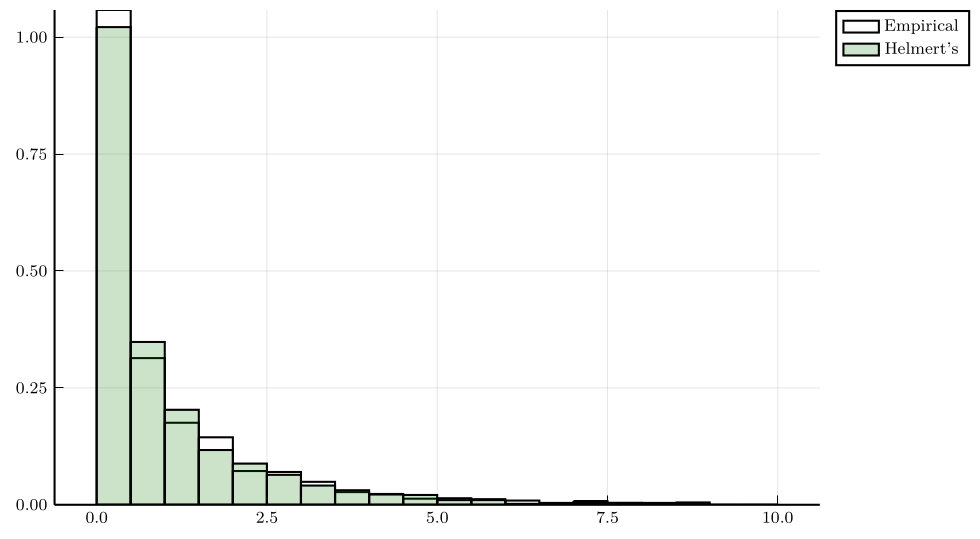

In [73]:
b_range = range(0, 10, length=21)
histogram([waldresult3 reference], label=["Empirical" "Helmert's"],bins=b_range,normalize = :pdf, color=[:red :green],fillalpha=[0.01 0.2])

Assuming full rank.

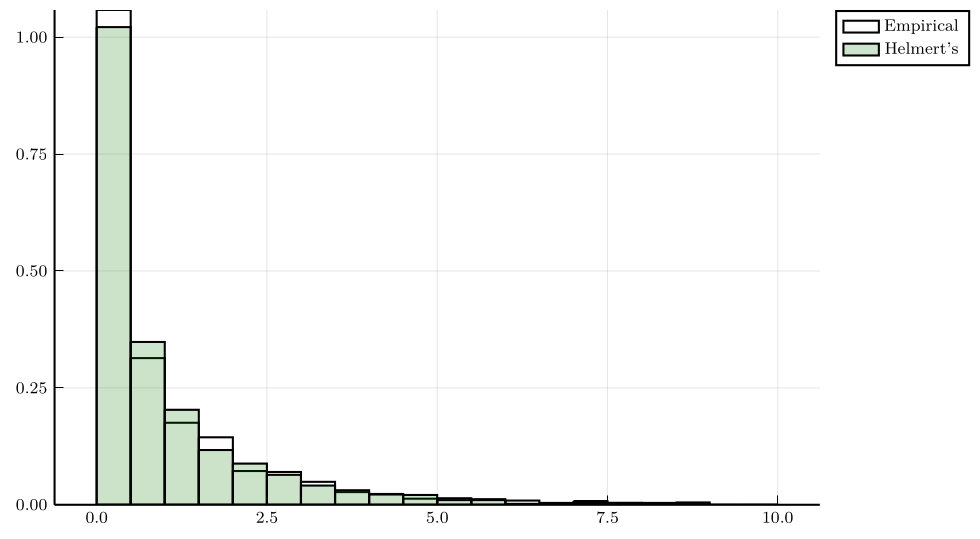

In [74]:
b_range = range(0, 10, length=21)
histogram([waldresult4 reference], label=["Empirical" "Helmert's"],bins=b_range,normalize = :pdf, color=[:red :green],fillalpha=[0.01 0.2])

Generate plot with density, correctly imposing reduced rank.

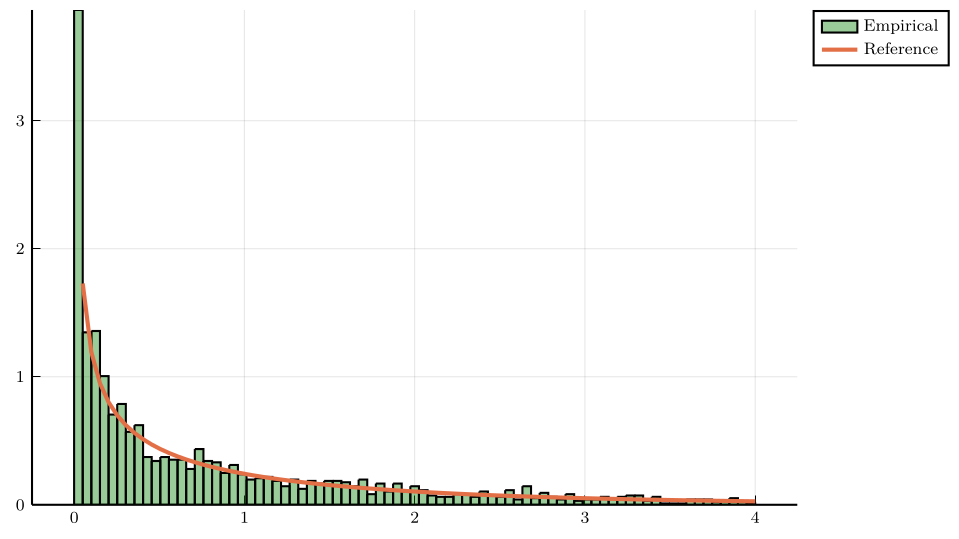

In [75]:
#import Pkg; Pkg.add("LaTeXStrings");
#using LaTeXStrings;
b_range2 = range(0, 4, length=80)
densplot=histogram(waldresult3, label="Empirical",bins=b_range2,normalize = :pdf, color=:green,fillalpha=0.4)
plot!(densplot,b_range2,Chisq(1),label="Reference",lw=2) #label=L"\chi^2_{1}"
densplot

Assuming full rank.

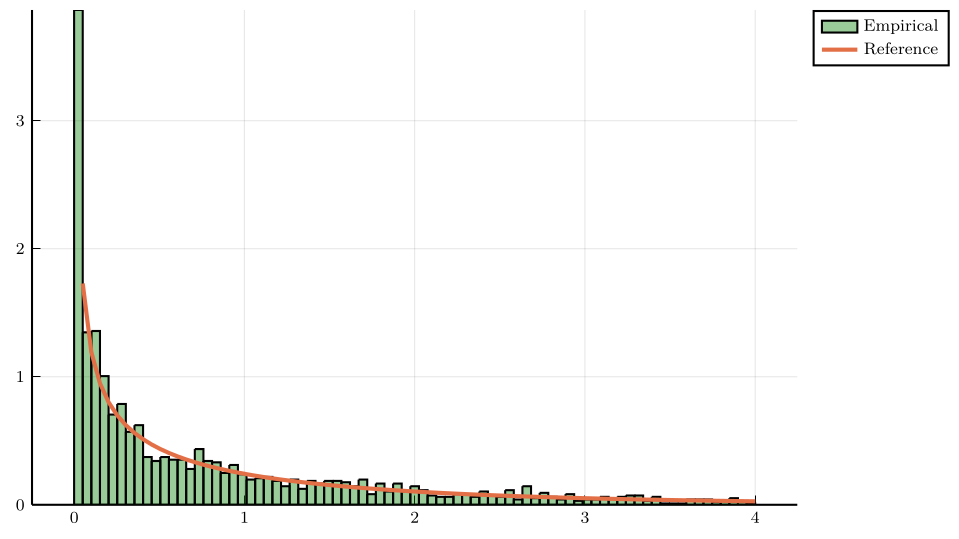

In [80]:
b_range2 = range(0, 4, length=80)
densplot_full_rank=histogram(waldresult4, label="Empirical",bins=b_range2,normalize = :pdf, color=:green,fillalpha=0.4)
plot!(densplot_full_rank,b_range2,Chisq(1),label="Reference",lw=2) #label=L"\chi^2_{1}"
densplot_full_rank

Assuming reduced rank.

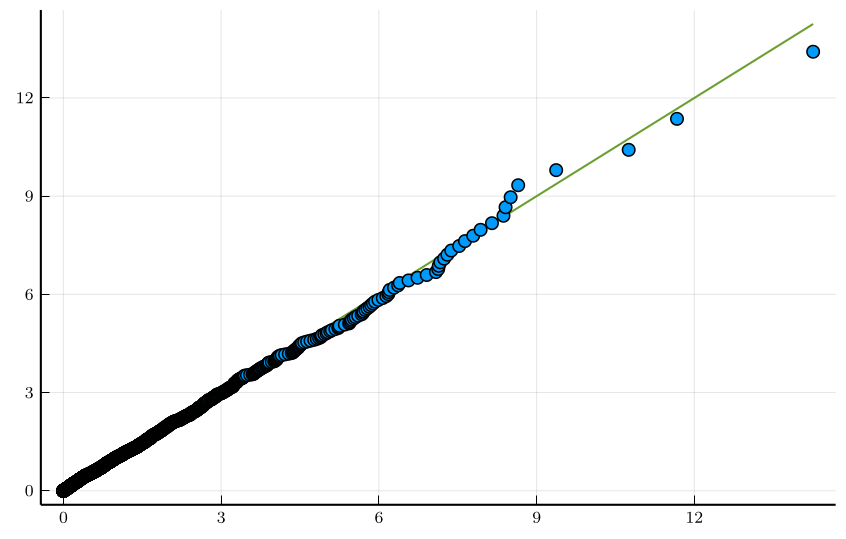

In [71]:
quant_plot = qqplot(waldresult3,Chisq(1))

Assuming full rank.

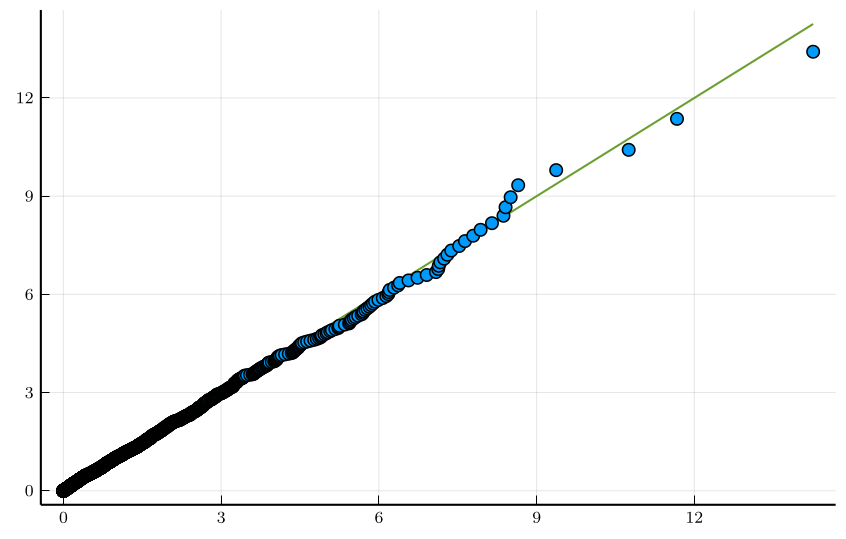

In [81]:
quant_plot_fullrank = qqplot(waldresult4,Chisq(1))

In [32]:
png(densplot,"density_wald_svd")

"density_wald_svd.png"

In [60]:
savefig(quant_plot,"qqplot2_svd.tex")
savefig(quant_plot,"qqplot2_svd.pdf")
savefig(quant_plot,"qqplot2_svd.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/qqplot2_svd.svg"

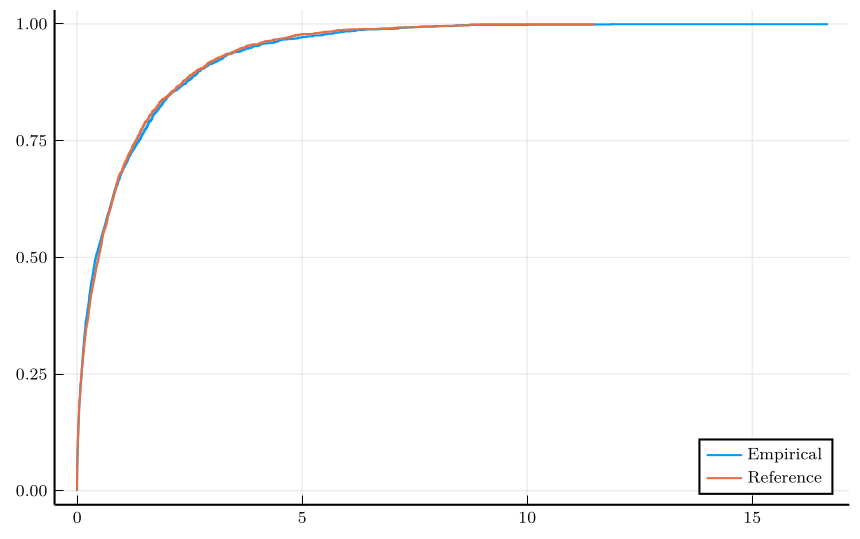

In [61]:
using StatsBase
scatter(ecdf(waldresult3),label="Empirical")
scatter!(ecdf(reference),label="Reference",legend=:bottomright)

In [62]:
png("cdfwald-svd")
savefig("cdfwald-svd.tex")
savefig("cdfwald-svd.pdf")
savefig("cdfwald-svd.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/cdfwald-svd.svg"

Estimate size using chi squared critical values

In [82]:
rejections = waldresult3 .> 3.841;
mean(rejections)

0.0515